# 2017 was the first year Florida, Florida State, and Miami all made the men's NCAA tournament

as cited here:

http://www.local10.com/sports/college-basketball/miami-florida-florida-state-all-heading-to-big-dance

but four Florida teams made the tournament this year including Florida Gulf Coast.  So is that the full story?  Have there been other years where three or more Florida teams made the tournament?  If so when and who were they?  Which Florida teams have the most appearances in the tournament?  

In [17]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
from bs4 import element
from time import sleep
import pandas as pd
import datetime
import matplotlib as plt
%matplotlib inline


def get_page_data(year):
    url = 'http://www.sports-reference.com/cbb/postseason/'+str(year)+'-ncaa.html'
    page = urlopen(url)
    return BeautifulSoup(page, 'html.parser')

def tidy_location(loc_str):
    if loc_str.startswith('at '):
        return loc_str[len('at '):]

def tidy_team_name(team_name):
    return team_name.rstrip(';')
    

In [18]:
first_year_of_tourney = 1939
def get_bracket():
    # this works for 84 first round bye and 85 and later 64+ team bracket ignoring play-in games
    now = datetime.datetime.now()
    years = range(now.year, first_year_of_tourney - 1, -1)
    bracket = []
    for year in years: 
        soup = get_page_data(year)
        region_tags = soup.find_all("div", attrs={"data-controls": "#brackets"})[0].select('div a')           
        for region_tag in region_tags:        
            region = str(region_tag.string).lower()                           
            if region == 'final four':
                region_div = soup.find('div', {'id':'national'})
            else:
                search = {'id': region} 
                region_div = soup.find('div',**search)            
            if region_div is not None:
                bracket_rounds = region_div.div
                div_rounds = bracket_rounds.find_all('div', {'class':'round'})                
                if region == 'final four':
                    bracket_round = 5
                else:
                    bracket_round = 1
                for div_round in div_rounds:
                    if isinstance(div_round, element.Tag ):
                        for gm in div_round:
                            if isinstance(gm, element.Tag ):
                                if (len(gm.contents) >= 9):
                                    seeds_loc = gm.find_all('span')
                                    if len(seeds_loc) > 2:                                        
                                        winner = gm.find('div', {'class':'winner'})
                                        if winner is not None:
                                            winning_team = tidy_team_name(winner.find('a').string)                                        
                                        seed1 = seeds_loc[0].string                                        
                                        seed2 = seeds_loc[1].string                                        
                                        currLoc = tidy_location(seeds_loc[2].string)        
                                        alist = gm.select('div a')    
                                        if len(alist) > 2:                                            
                                            team1 = tidy_team_name(alist[0].string)                                            
                                            team2 = tidy_team_name(alist[2].string)
                                            bracketRow = [year, region, bracket_round, seed1, team1, 
                                                          currLoc, seed2, team2, winning_team]
                                            bracket.append(bracketRow)
                        bracket_round += 1
        sleep(0.5)
    return pd.DataFrame(bracket, columns=['Year', 'Region', 'Round', 'Seed', 'Team', 
                                          'Location', 'OpponentSeed', 'Opponent', 'WinningTeam']) 

    
df = get_bracket()
df.to_csv('ncaa.csv')

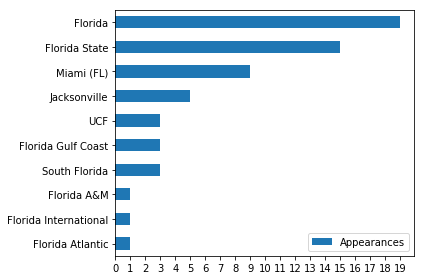

In [19]:
df1 = df.loc[(df['Round'] == 1)]
fl_list = ['Florida', 'Florida State', 'Miami (FL)', 'Jacksonville', 'UCF', 'Florida Gulf Coast', 'South Florida', 'Florida A&M','Florida International', 'Florida Atlantic']

df1_teams_year = df1.loc[:, ['Year','Team','Opponent']]
df1_teams = df1.loc[:, ['Team','Opponent']]

fl_team_app = []
for fl_tm in fl_list:
    fl_tm_count = df1_teams[(df1_teams.Team == fl_tm) | (df1_teams.Opponent == fl_tm)]
    fl_team_app.append([fl_tm, len(fl_tm_count.index)])
sorted(fl_team_app, key=lambda l:l[1], reverse=True)


df_fl_team_app = pd.DataFrame(fl_team_app, columns=['Team', 'Appearances'])
ax = df_fl_team_app.plot.barh(xticks=range(0, df_fl_team_app.Appearances.max()+1))
ax.set_yticklabels(df_fl_team_app.Team)
ax.invert_yaxis()

ax.figure.tight_layout()


ax.figure.savefig('florida_teams_ncaa_appearances.png')

In [62]:
team_counts= df1_teams.stack().value_counts()

#print(team_counts[:25])
#team_counts_df = pd.DataFrame(team_counts, columns=['Team', 'Number of NCAA Appearances'])
#team_counts_df.to_csv('ncaa_team_appearances.csv')

#team_counts_df
team_counts.describe()

team_counts_df = pd.DataFrame(team_counts.reset_index())
team_counts_df.columns = ['Team', 'Appearances']

team_counts_df['rank'] = team_counts_df['Appearances'].rank(ascending=0, method='dense')


team_counts_df_rank_series = team_counts_df['rank']
team_counts_df_rank_series
team_counts_df['rank'] = team_counts_df_rank_series.astype(int)
team_counts_df
team_counts_df.to_csv('ncaa_team_appearances.csv')

In [21]:
fl_teams_by_year = df1_teams_year[df1_teams_year.Team.isin(fl_list)|df1_teams_year.Opponent.isin(fl_list)] 
fl_teams_by_year
fl_teams_by_year.to_csv('fl_teams_by_year.csv')

In [22]:
fl_teams_by_year

,Year,Team,Opponent
3,2017,Florida,ETSU
16,2017,Miami (FL),Michigan State
49,2017,Florida State,Florida Gulf Coast
62,2016,UNC,Florida Gulf Coast
97,2016,Miami (FL),Buffalo
233,2014,Florida,Albany (NY)
258,2013,Miami (FL),Pacific
286,2013,Florida,Northwestern State
288,2013,Georgetown,Florida Gulf Coast
319,2012,Florida State,St. Bonaventure


In [43]:
df1_teams_year_t = df1_teams_year.loc[:, ['Year','Team']][df1_teams_year.Team.isin(fl_list)]
df1_teams_year_o = df1_teams_year.loc[:, ['Year','Opponent']][df1_teams_year.Opponent.isin(fl_list)]
df1_teams_year_o.rename(columns={'Opponent':'Team'}, inplace=True)
df1_teams_fl_agg = pd.concat([df1_teams_year_t, df1_teams_year_o])
df1_teams_fl_agg.groupby('Year')
final_count = df1_teams_fl_agg.groupby('Year').count().sort_index(axis=0, ascending=False)
fl_three_or_more = final_count[final_count.values >= 3]
fl_three_or_more_df = pd.DataFrame(fl_three_or_more.reset_index())
fl_three_or_more_df.columns = ['Year', 'Appearances']
fl_three_or_more_df.to_csv("fl_three_or_more.csv")
fl_three_or_more_df

,Year,Appearances
0,2017,4
1,2013,3
2,2012,3
3,2002,3
4,1999,3


In [45]:
df1_teams_fl_agg[df1_teams_fl_agg.Year.isin(fl_three_or_more.index)].sort_values(by=['Year'], ascending=False)


,Year,Team
3,2017,Florida
16,2017,Miami (FL)
49,2017,Florida State
49,2017,Florida Gulf Coast
258,2013,Miami (FL)
286,2013,Florida
288,2013,Florida Gulf Coast
319,2012,Florida State
365,2012,Florida
331,2012,South Florida
